In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#import packages for w2v
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\prade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

# Data Preprocessing

In [3]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
import datetime
#filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
filtered_data["Time"]=pd.to_datetime(filtered_data["Time"], format='%Y-%m-%d %H:%M:%S')

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [6]:
#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

print(final.shape)

(364173, 10)


(2000, 10)


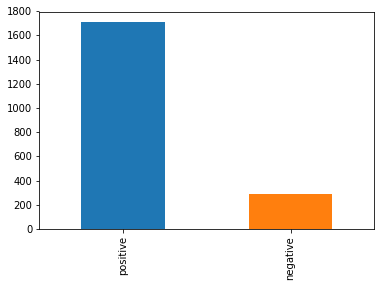

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final=final.sample(2000)
print(final.shape)
#To know how many positive and negative reviews are present in our dataset
final['Score'].value_counts()
final['Score'].value_counts().plot(kind='bar')

# Removing stopwords, punctuation and then we do stemming

In [8]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'our', 'more', 'didn', "haven't", 'ma', 'or', 'does', 'few', "won't", 'ain', 'very', "you've", 'we', "doesn't", 'all', 'wasn', 'hadn', 'and', 'ourselves', 'but', 'your', 'whom', 'me', 'on', 'when', "it's", 'isn', 'you', 'further', 'over', 'before', "aren't", 'once', 'had', 'at', 'during', 'couldn', 'don', 'this', 'hers', 'doing', 'can', 'any', 'no', 'only', 'them', 'themselves', 'being', 'will', 'other', 'won', 'o', "you're", 'hasn', 'my', 'until', 'now', 'down', 'are', "you'd", 'yours', 've', 'so', "should've", "shan't", 'ours', 'here', 'yourselves', 'am', 'm', 'what', "wouldn't", 't', 'as', 'same', "she's", 'him', 'up', 'yourself', 'wouldn', 'myself', 'has', 'which', 'under', 'll', 'himself', 'herself', 'her', 'to', 'd', 'weren', 'nor', "mustn't", 'from', 'there', "couldn't", 'needn', "you'll", 'should', 'some', 'in', 'that', 'too', 'those', 'did', 'an', 'each', "needn't", 'for', 'its', 'off', 'be', 'after', "mightn't", 'do', 'into', 're', 'then', 'how', 'where', 'such', 'while', 'n

In [9]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
print(final['CleanedText'])

285558    look shorter bamboo stalk answer mail receiv q...
12451     love love love well season thick greasi yum mu...
33358     first found product local supermarket usual li...
350424    pictur show chicken ramen mushroom flavor vege...
66987     fantast hot cereal great altern oatmeal gluten...
266860    whole wheat flour ill use use make infam simpl...
218604    expens get cole week bonus flybuy well realli ...
91978     tea sometim known betti tearoom blend betti wo...
133886    dont know magic ingredi might perhap fennel al...
268650    favorit curri smooth flavor wonder aroma heat ...
281991    stem ginger sweet kick great munch digest aid ...
348005    cant beat amazon price best price could find c...
315962    thought might come apart coffe machin held per...
110941    work well larg area keep anim children yard ne...
223465    first got hook green tea matcha powder order g...
307633    use sever jelli belli snow cone flavor kid lov...
26541     first true gut feel rate three

In [11]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [12]:
#method for finding optimal value of k
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def finding_opt_k(X_train, y_train):
# creating odd list of K for KNN
    myList = list(range(0,100))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k

In [13]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
def confusion_matrix_plot(y_test,pred):
    labels = ['negative','positive']
    cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Bag of Words

In [14]:
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final['CleanedText'])

In [15]:
X = final_bow_count
y = final['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


The optimal number of neighbors is 11.


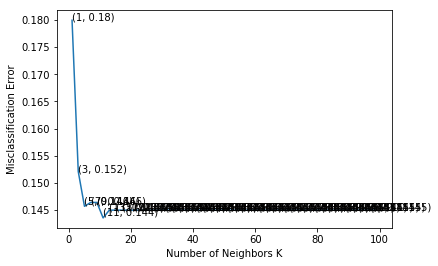

the misclassification error for each k value is :  [0.18  0.152 0.146 0.146 0.146 0.144 0.145 0.145 0.145 0.145 0.145 0.145
 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145
 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145
 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145
 0.145 0.145]

The accuracy of the knn classifier for k = 11 is 85.666667%


In [16]:
from sklearn.metrics import accuracy_score
optimal_k=finding_opt_k(X_train,y_train)
#KNN with brute force technique
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'brute')
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

[[  0  99]
 [  0 501]]


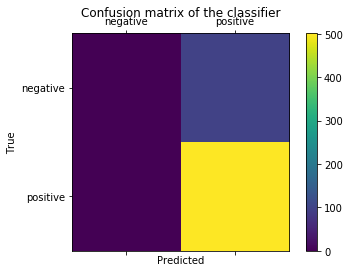

In [17]:
confusion_matrix_plot(y_test,pred)

In [18]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 15 is 83.500000%


[[  0  99]
 [  0 501]]


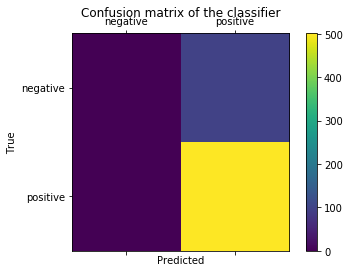

In [19]:
confusion_matrix_plot(y_test,pred)

# TF-IDF

In [20]:
tf_idf_vec = TfidfVectorizer()
final_tfidf_count = tf_idf_vec.fit_transform(final_string)

In [21]:
from sklearn.preprocessing import StandardScaler

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count )

In [22]:
X = final_tfidf_np
y = final['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


The optimal number of neighbors is 5.


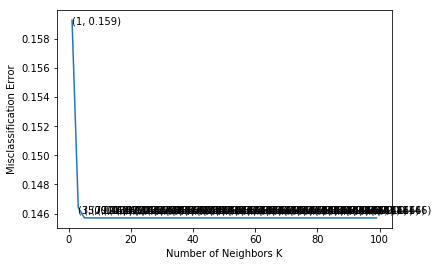

the misclassification error for each k value is :  [0.159 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146]

The accuracy of the knn classifier for k = 5 is 83.500000%


In [23]:
optimal_k=finding_opt_k(X_train,y_train)
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn.fit(X_train, y_train)
pred1 = knn.predict(X_test)
acc = accuracy_score(y_test, pred1) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

[[  0  99]
 [  0 501]]


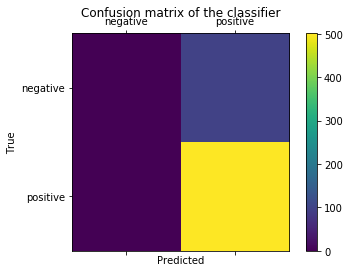

In [24]:
confusion_matrix_plot(y_test,pred)


The accuracy of the knn classifier for k = 5 is 83.500000%
[[  0  99]
 [  0 501]]


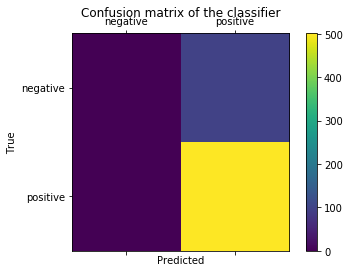

In [25]:
#KNN with KD-tree
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
confusion_matrix_plot(y_test,pred)

# Avg W2V

In [26]:
import gensim
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [27]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [28]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [29]:
final_w2v_count = StandardScaler().fit_transform(sent_vectors )

X = final_w2v_count
y = final['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


The optimal number of neighbors is 23.


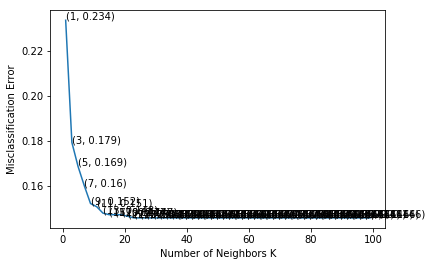

the misclassification error for each k value is :  [0.234 0.179 0.169 0.16  0.152 0.151 0.148 0.147 0.147 0.147 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146]

The accuracy of the knn classifier for k = 23 is 83.333333%


In [30]:
optimal_k=finding_opt_k(X_train,y_train)
#KNN with brute force technique
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

[[  0  99]
 [  1 500]]


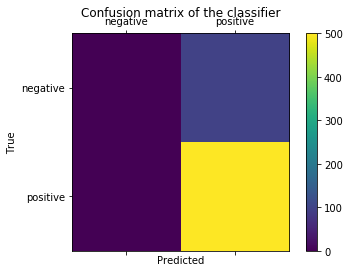

In [31]:
confusion_matrix_plot(y_test,pred)


The accuracy of the knn classifier for k = 23 is 83.333333%
[[  0  99]
 [  1 500]]


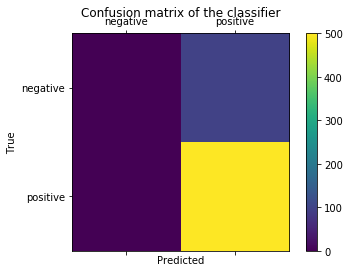

In [32]:
#KNN with KD-tree
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = 'kd_tree')
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
confusion_matrix_plot(y_test,pred)

[[  0  99]
 [  1 500]]


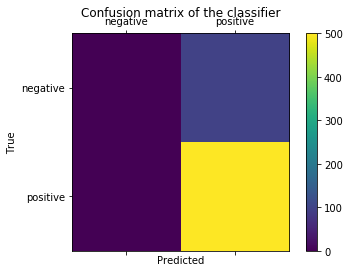

In [33]:
confusion_matrix_plot(y_test,pred)

# TF-IDF W2V

In [34]:
tf_idf_vec_w = TfidfVectorizer()

final_tfidf_w = tf_idf_vec_w.fit_transform(final_string_for_tfidf)
tfidf_feature = tf_idf_vec_w.get_feature_names()
tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feature.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1


In [35]:
from sklearn.preprocessing import StandardScaler

final_tfidf_w2v = StandardScaler().fit_transform(tfidf_sent_vectors )
X = final_tfidf_w2v
y = final['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


The optimal number of neighbors is 13.


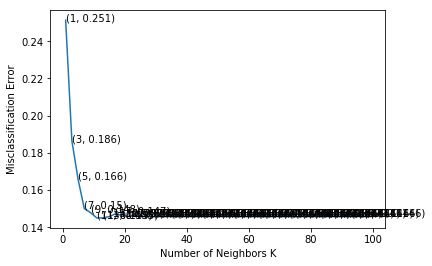

the misclassification error for each k value is :  [0.251 0.186 0.166 0.15  0.148 0.145 0.145 0.146 0.147 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146]

The accuracy of the knn classifier for k = 13 is 83.166667%


In [36]:
#KNN with brute force technique
optimal_k=finding_opt_k(X_train,y_train)
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

[[  1  98]
 [  3 498]]


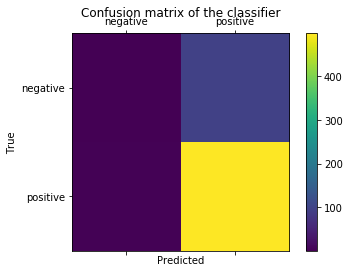

In [37]:
confusion_matrix_plot(y_test,pred)


The optimal number of neighbors is 13.


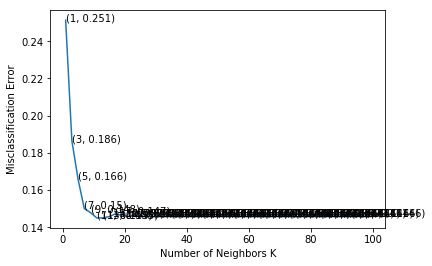

the misclassification error for each k value is :  [0.251 0.186 0.166 0.15  0.148 0.145 0.145 0.146 0.147 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146 0.146
 0.146 0.146]

The accuracy of the knn classifier for k = 13 is 83.166667%


In [38]:
#KNN with KD-tree
optimal_k=finding_opt_k(X_train,y_train)
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

[[  1  98]
 [  3 498]]


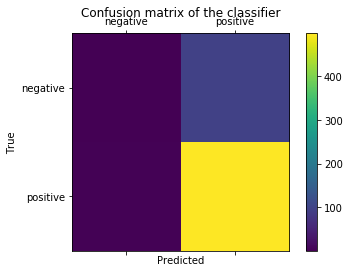

In [39]:
confusion_matrix_plot(y_test,pred)